In [1]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/home/jadli/Bureau/BDAI2/Satellite_Super_Resulotion0")

import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from importlib import reload
import src.utils.config
reload(src.utils.config)
from src.utils.config import CONFIG

from src.utils.data_loader import create_loaders
from src.models.models_architecture import EDSR       
from src.utils.helper_functions import train_sr, val_sr, plot_sr_progress

import json

best_model_path = CONFIG["model"]["best_EDSR_path"]
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device : {device}")

# CONFIG FROM YAML 
data_root      = CONFIG["paths"]["output_root"]
batch_size     = CONFIG["training"]["batch_size"]
num_workers    = CONFIG["training"]["num_workers"]
use_aug        = CONFIG["training"].get("use_augmentation", True)

# HYPERPARAMS FROM CONFIG 
lr              = 0.0001 #CONFIG["training"]["lr"]
weight_decay    = CONFIG["training"]["weight_decay"]
num_epochs      = 1  #CONFIG["training"]["epochs"]
step_size       = 8 #CONFIG["training"]["scheduler_step_size"]
gamma           = 0.5 #CONFIG["training"]["scheduler_gamma"]


# LOAD DATA 

train_loader, val_loader, test_loader = create_loaders(
    root=data_root,
    batch_size=batch_size,
    num_workers=num_workers,
    use_augmentation=use_aug
)



device : cuda

 DATA LOADED:
  Train: 64800 samples
  Val:   8100 samples
  Test:  8100 samples


/tmp/ipykernel_99785/3726899703.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


Loading checkpoint: src/models/checkpoints/EDSR/best_EDSR.pth
 Resuming training from epoch 24 | Best PSNR = 27.25
 Loading training history...

Epoch 25/25


 New BEST model saved at epoch 25 with PSNR = 27.26
Train loss: 0.002605 | Train PSNR: 25.87 dB
Val   loss: 0.002245 | Val   PSNR: 27.26 dB
-> LR: 0.00005000


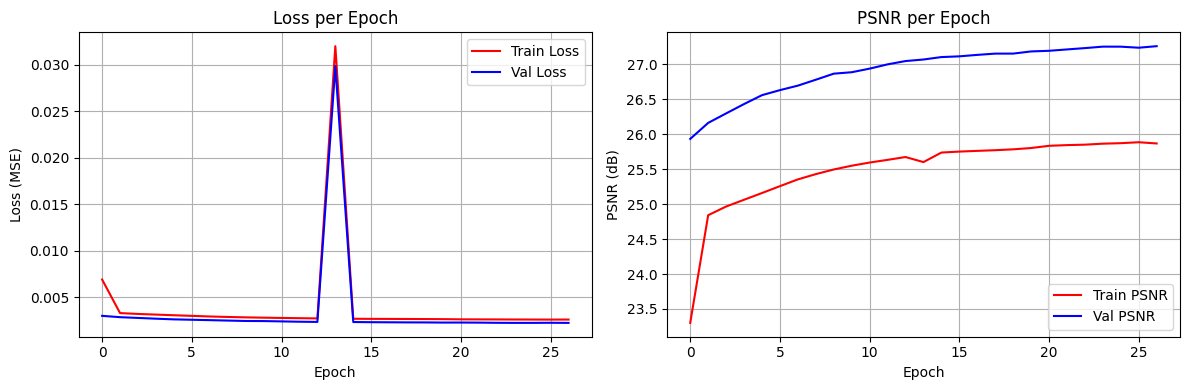

In [2]:

model = EDSR().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


best_psnr = 0.0
best_model_path = CONFIG["model"]["best_EDSR_path"]
history_path = CONFIG["model"]["history_path"]
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
os.makedirs(os.path.dirname(history_path), exist_ok=True)


# LOAD CHECKPOINT IF EXISTS
start_epoch = 0

if os.path.exists(best_model_path):
    print("Loading checkpoint:", best_model_path)
    checkpoint = torch.load(best_model_path, map_location=device)

    if "model" in checkpoint:
        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scheduler.load_state_dict(checkpoint["scheduler"])
        best_psnr = checkpoint["best_psnr"]
        start_epoch = checkpoint["epoch"] + 1
        print(f" Resuming training from epoch {start_epoch} | Best PSNR = {best_psnr:.2f}")
    else:
        print(" Old checkpoint without optimizer/scheduler. Loading model only.")
        model.load_state_dict(checkpoint)
else:
    print(" Training from scratch")


# LOAD TRAINING HISTORY
train_losses, val_losses = [], []
train_psnrs, val_psnrs = [], []

if os.path.exists(history_path):
    print(" Loading training history...")
    with open(history_path, "r") as f:
        history = json.load(f)

    train_losses = history["train_losses"]
    val_losses   = history["val_losses"]
    train_psnrs  = history["train_psnrs"]
    val_psnrs    = history["val_psnrs"]
else:
    print("No previous training history found.")


# TRAIN LOOP
num_epochs += start_epoch  

for epoch in range(start_epoch, num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # TRAIN
    train_loss, train_psnr = train_sr(
        model=model,
        train_loader=train_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        device=device,
        scale_factor=4,
        model_requires_upscale=False,
        scheduler=scheduler
    )

    # VALIDATION
    val_loss, val_psnr = val_sr(
        model=model,
        val_loader=val_loader,
        loss_fn=criterion,
        device=device,
        scale_factor=4,
        model_requires_upscale=False
    )

    # SAVE BEST MODEL
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        torch.save({
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "epoch": epoch,
            "best_psnr": best_psnr,
        }, best_model_path)

        print(f" New BEST model saved at epoch {epoch+1} with PSNR = {best_psnr:.2f}")

    # APPEND HISTORY
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_psnrs.append(train_psnr)
    val_psnrs.append(val_psnr)

    # SAVE HISTORY
    history = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_psnrs": train_psnrs,
        "val_psnrs": val_psnrs
    }
    with open(history_path, "w") as f:
        json.dump(history, f)

    print(f"Train loss: {train_loss:.6f} | Train PSNR: {train_psnr:.2f} dB")
    print(f"Val   loss: {val_loss:.6f} | Val   PSNR: {val_psnr:.2f} dB")
    print(f"-> LR: {optimizer.param_groups[0]['lr']:.8f}")

# FINAL PLOT
plot_sr_progress(train_losses, val_losses, train_psnrs, val_psnrs)
